# CancerRisk - Model Prediction

Here we provide a notebook to showcase the use of the the model. 



In [1]:
!pip3 install probcox
!gdown 1a7v5l7XwOIT9n4zc8tMzesoDoihng32k # model param
!gdown 1HLf54s0OC-HdTBEbEZxFD8mVi8kKVQaX # disease codes
!gdown 1hNYW3CexHSNz-myAeBO_A9XhIR1EC6oC # model
!tar -xvf model.tar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 607 kB 7.2 MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-py3-none-any.whl size=5224 sha256=812a175d0984e0ade5b5f4cc82a3ca52754fdbe164da8b101743ef335406b7f2
  Stored in directory: /root/.cache/pip/wheels/7b/6c/69/1adac1abb2e1e8c9d58200fa7a181920d2f7c90809c837d47a
Successfully built probcox
Downloading...
From: https://drive.google.com/uc?id=1a7v5l7XwOIT9n4zc8tMzesoDoihng32k
To: /content/model.tar
100% 638M/638M [00:04<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HLf54s0OC-HdTBEbEZxFD8mVi8kKVQaX
To: /content/disease_codes.npy
100% 89.6k/89.6k [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hNYW3CexHSNz-myAeBO_A9XhIR1EC6oC
To: /content/m1.py
100% 959/959 [00:00<00:

In [1]:
# Modules
# =======================================================================================================================
import pickle
import sys
import torch 
import pyro 

import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt


events = ['oesophagus', 'stomach', 'colorectal', 'liver', 'pancreas', 'lung', 'melanoma', 'breast', 
                'cervix_uteri', 'corpus_uteri', 'ovary', 'prostate', 'testis', 'kidney', 'bladder', 'brain',
                'thyroid', 'non_hodgkin_lymphoma', 'multiple_myeloma', 'AML', 'other', 'death']

for cc in range(22):
    print(cc, events[cc])

disease_codes = np.load('/content/disease_codes.npy', allow_pickle=True)
gene_names = np.asarray([jj+ii for jj in events[:20] for ii in [' First Degree', ' All', ' Multiple', ' Early']])
bth_names = np.asarray(['Alcoholic', 'Smoker', 'High Blood Pressure', 'Low Blood Pressure', 'Height', 'Weight', 'Age at first Birth'])

sys.path.append('/content/')
from m1 import predictor

dtype = torch.FloatTensor 

np.random.seed(243)
torch.manual_seed(53) 
pyro.set_rng_seed(85)

# Plot Settings
# =======================================================================================================================
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.grid'] = False

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['font.size'] = 6
fontsize=6

cm = 1/2.54
colormap= np.asarray(['#1E90FF', '#BFEFFF', '#191970', '#87CEFA', '#008B8B', '#946448', '#421a01', '#6e0b3c', 
                '#9370DB', '#7A378B', '#CD6090', '#006400', '#5ebd70', '#f8d64f', '#EEAD0E', '#f8d6cf',
                '#CDCB50', '#CD6600', '#FF8C69', '#8f0000', '#b3b3b3', '#454545'])


# Custom functions
# =======================================================================================================================
class CIF():
    def __init__(self, cc, tt0, tt_range, A0, pred, sex, full=False, **kwds):
        self.cc = cc
        self.tt0 = tt0
        self.tt_range = tt_range
        self.A0 = A0 
        self.pred = pred 
        self.sex = sex
        self.full = full # including all otherwise only the 20 major cancer types are considered
        self.sexnames = ['female', 'male']
        
    def __call__(self, ii):
        A0net = np.sum((self.A0[:, self.sex[ii], self.tt0[ii]:self.tt0[ii]+self.tt_range]*np.exp(self.pred[ii, :, None])), axis=0)
        S0net = np.exp(-np.cumsum(A0net))
        
        if self.full:
            pest = np.cumsum(self.A0[:20, self.sex[ii], self.tt0[ii]:self.tt0[ii]+self.tt_range]*np.exp(self.pred[ii, :20, None]) * S0net[None, :], axis=1)[:, -1].sum()
            
        else:
            pest = np.cumsum(self.A0[self.cc, self.sex[ii], self.tt0[ii]:self.tt0[ii]+self.tt_range] * np.exp(self.pred[ii, self.cc, None]) * S0net)[-1]
        return([pest])

0 oesophagus
1 stomach
2 colorectal
3 liver
4 pancreas
5 lung
6 melanoma
7 breast
8 cervix_uteri
9 corpus_uteri
10 ovary
11 prostate
12 testis
13 kidney
14 bladder
15 brain
16 thyroid
17 non_hodgkin_lymphoma
18 multiple_myeloma
19 AML
20 other
21 death


FileNotFoundError: [Errno 2] No such file or directory: '/content/disease_codes.npy'

In [3]:
column_headers = np.concatenate((disease_codes[:, 1], gene_names, bth_names)) # covaraite ordering

In [4]:
## Model
#=======================================================================================================================
tt = [pickle.load(open('/content/model/' + events[cc] + '/param.pkl', 'rb')) for cc in range(22)]
A0 = np.load('/content/model/' + 'all' + '/breslow.npy') 

In [5]:
## Fake Data
#=======================================================================================================================
dnpr_dummies = np.random.binomial(1, 0.01, (1, 1305)) # random indicators for differnt disease [0, 1]
print(pd.DataFrame(disease_codes[dnpr_dummies.astype(bool)[0, :], 1])) # list of diseases

genealogy = np.random.binomial(1, 0.05, (1, 80)) # random indicators for differnt genealogy indicators [-1, 0, 1]
print(pd.DataFrame(gene_names[genealogy.astype(bool)[0, :]])) # list of family cases

bth = np.asarray([[1, 1, 0, 0, 1.9, 0.81, 0]])
print(pd.DataFrame(np.concatenate([bth_names[:, None], bth.T], axis=1))) # list of family cases

sex = np.asarray([1]) # male - (female==0)

column_headers = np.concatenate((disease_codes[:, 1], gene_names, bth_names)) # covariate ordering

X = np.concatenate((dnpr_dummies, genealogy, bth), axis=1)

                                                   0
0  F19 Mental and behavioural disorders due to mu...
1              G52 Disorders of other cranial nerves
2                     G82 Paraplegia and tetraplegia
3       H21 Other disorders of iris and ciliary body
4       H66 Suppurative and unspecified otitis media
5            I69 Sequelae of cerebrovascular disease
6                                 L68 Hypertrichosis
7  P25 Interstitial emphysema and related conditi...
8                   R74 Abnormal serum enzyme levels
                      0
0             liver All
1  multiple_myeloma All
                     0     1
0            Alcoholic   1.0
1               Smoker   1.0
2  High Blood Pressure   0.0
3   Low Blood Pressure   0.0
4               Height   1.9
5               Weight  0.81
6   Age at first Birth   0.0


In [6]:
## Prediction (Log-Hazard)
#=======================================================================================================================
pp=[]
for cc in (range(len(tt))):
    pyro.clear_param_store()
    with torch.no_grad(): 
        #tt = pickle.load(open(dir_out + 'm1/model/' + events[cc] + '/param.pkl', 'rb'))
        mm = tt[cc]['model']        
        gg = tt[cc]['guide']

        theta_dnpr = gg.quantiles([0.5])['theta_dnpr'][0].detach().numpy()
        theta_gene = gg.quantiles([0.5])['theta_gene'][0].detach().numpy()
        theta_bth = gg.quantiles([0.5])['theta_bth'][0].detach().numpy()

        p_dnpr = np.matmul(dnpr_dummies, theta_dnpr.T)
        p_gene = np.matmul(genealogy, theta_gene.T)
        p_bth = np.matmul(bth, theta_bth.T)
        pred = p_dnpr + p_gene + p_bth 
        pp.extend([pred])
pp= np.squeeze(np.stack(pp)).T

In [7]:
## Prediction (Absolute)
#=======================================================================================================================
risk = []
for cc in range(20): # loop over each cancer
    rr =[]
    for aa in (range(1, 5*365)): # evalaute risk for each day in the next 5 years
      cif_ = CIF(cc=cc, tt0=np.asarray([50*365]), tt_range=aa, A0=A0, pred=pp[None, :], sex=sex, full=False)
      rr.extend([cif_(0)])
    risk.extend([rr])
risk = np.squeeze(risk)

# prediction without any covariate info.
risk2 = []
for cc in range(20): # loop over each cancer
    rr =[]
    for aa in (range(1, 5*365)): # evalaute risk for each day in the next 5 years
      cif_ = CIF(cc=cc, tt0=np.asarray([50*365]), tt_range=aa, A0=A0, pred=np.zeros_like(pp[None, :]), sex=sex, full=False)
      rr.extend([cif_(0)])
    risk2.extend([rr])
risk2 = np.squeeze(risk2)

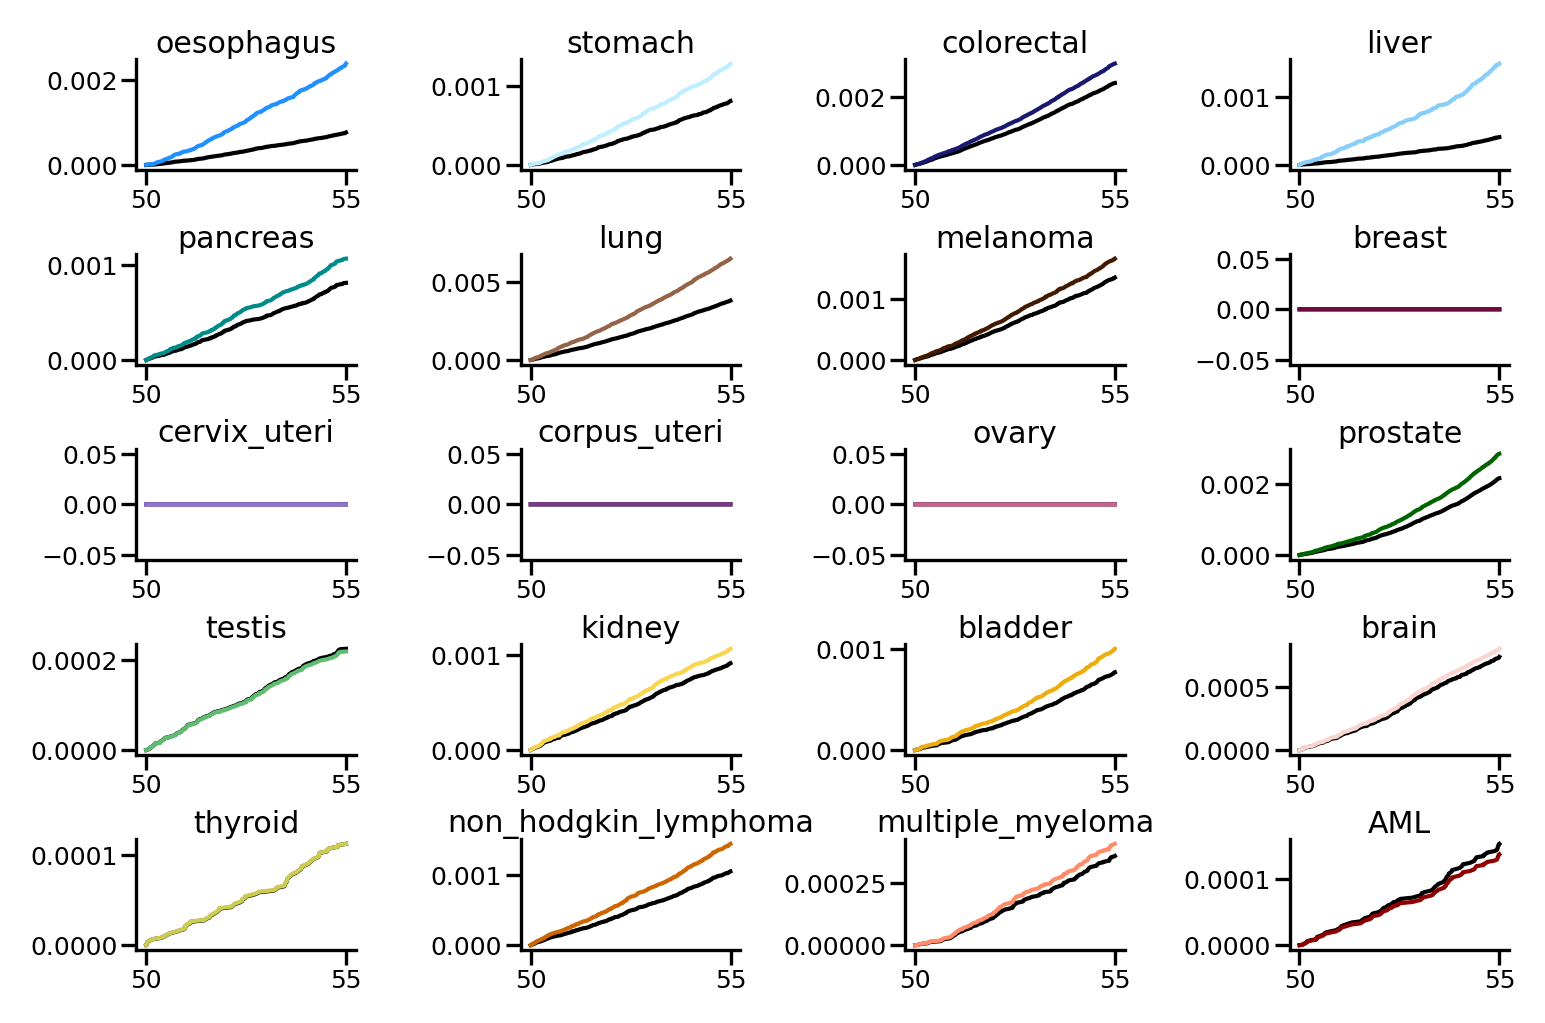

In [8]:
## Plot of trajectories
#=======================================================================================================================
fig, ax = plt.subplots(5, 4, figsize=(15*cm, 10*cm), dpi=300)
plt.subplots_adjust(wspace=0.75, hspace=0.75)
row=0
col=0
for cc in range(20):
  ax[row, col].plot(50 + np.arange(1, 5*365)/365, risk2[cc, :], color='black', lw=1)
  ax[row, col].plot(50 + np.arange(1, 5*365)/365, risk[cc, :], color=colormap[cc], lw=-1)
  ax[row, col].set_title(events[cc])
  col += 1
  if col == 4:
    col = 0 
    row += 1

plt.show()
plt.close()